In [5]:
from math import sqrt, atan2, pi
import numpy as np

def canny_edge_detector(input_image):
    input_pixels = input_image.load()
    width = input_image.width
    height = input_image.height

    # Transform the image to grayscale
    grayscaled = compute_grayscale(input_pixels, width, height)

    
    
    # Blur it to remove noise
    blurred = compute_blur(grayscaled, width, height)

    
    # Compute the gradient
    gradient, direction = compute_gradient(blurred, width, height)

    
    # Non-maximum suppression
    filter_out_non_maximum(gradient, direction, width, height)

    
    # Filter out some edges
    keep = filter_strong_edges(gradient, width, height, 20, 25)

    return keep


def compute_grayscale(input_pixels, width, height):
    grayscale = np.empty((width, height))
    for x in range(width):
        for y in range(height):
            pixel = input_pixels[x, y]
            grayscale[x, y] = (pixel[0] + pixel[1] + pixel[2]) / 3
    return grayscale


def compute_blur(input_pixels, width, height):
    # Keep coordinate inside image
    clip = lambda x, l, u: l if x < l else u if x > u else x

    # Gaussian kernel
    kernel = np.array([
        [1 / 256,  4 / 256,  6 / 256,  4 / 256, 1 / 256],
        [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
        [6 / 256, 24 / 256, 36 / 256, 24 / 256, 6 / 256],
        [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
        [1 / 256,  4 / 256,  6 / 256,  4 / 256, 1 / 256]
    ])

    # Middle of the kernel
    offset = len(kernel) // 2

    
    # Compute the blurred image
    blurred = np.empty((width, height))
    for x in range(width):
        for y in range(height):
            acc = 0
            for a in range(len(kernel)):
                for b in range(len(kernel)):
                    xn = clip(x + a - offset, 0, width - 1)
                    yn = clip(y + b - offset, 0, height - 1)
                    acc += input_pixels[xn, yn] * kernel[a, b]
            blurred[x, y] = int(acc)
    return blurred


def compute_gradient(input_pixels, width, height):
    gradient = np.zeros((width, height))
    direction = np.zeros((width, height))
    for x in range(width):
        for y in range(height):
            if 0 < x < width - 1 and 0 < y < height - 1:
                magx = input_pixels[x + 1, y] - input_pixels[x - 1, y]
                magy = input_pixels[x, y + 1] - input_pixels[x, y - 1]
                gradient[x, y] = sqrt(magx**2 + magy**2)
                direction[x, y] = atan2(magy, magx)
    return gradient, direction


def filter_out_non_maximum(gradient, direction, width, height):
    for x in range(1, width - 1):
        for y in range(1, height - 1):
            angle = direction[x, y] if direction[x, y] >= 0 else direction[x, y] + pi
            rangle = round(angle / (pi / 4))
            mag = gradient[x, y]
            if ((rangle == 0 or rangle == 4) and (gradient[x - 1, y] > mag or gradient[x + 1, y] > mag)
                    or (rangle == 1 and (gradient[x - 1, y - 1] > mag or gradient[x + 1, y + 1] > mag))
                    or (rangle == 2 and (gradient[x, y - 1] > mag or gradient[x, y + 1] > mag))
                    or (rangle == 3 and (gradient[x + 1, y - 1] > mag or gradient[x - 1, y + 1] > mag))):
                gradient[x, y] = 0


def filter_strong_edges(gradient, width, height, low, high):
    # Keep strong edges
    keep = set()
    for x in range(width):
        for y in range(height):
            if gradient[x, y] > high:
                keep.add((x, y))

    # Keep weak edges next to a pixel to keep
    lastiter = keep
    while lastiter:
        newkeep = set()
        for x, y in lastiter:
            for a, b in ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)):
                if gradient[x + a, y + b] > low and (x+a, y+b) not in keep:
                    newkeep.add((x+a, y+b))
        keep.update(newkeep)
        lastiter = newkeep

    return list(keep)


if __name__ == "__main__":
    from PIL import Image, ImageDraw
    input_image = Image.open("input.png")
    output_image = Image.new("RGB", input_image.size)
    draw = ImageDraw.Draw(output_image)
    for x, y in canny_edge_detector(input_image):
        draw.point((x, y), (255, 255, 255))
    output_image.save("canny.png")

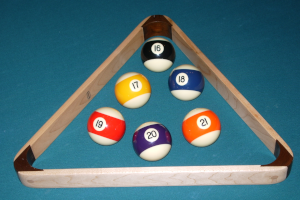

In [6]:
Image.open("input.png")

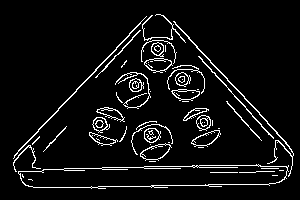

In [7]:
output_image